# Reproduce the Results for the Public Datasets

Here, we report the code to reproduce the results reported in our work "GHOST: Adjusting the Decision Threshold to Handle Imbalanced Data in Machine Learning".

Especially, the code below allows to train four different machine learning classifiers (random forest, gradient boosting, XGBoost, and logistic regression) in combination with two different molecular descriptors (ECFP4 and RDKit2D). The models are trained on 138 public datasets, which are described and used in [this RDKit blog post](http://rdkit.blogspot.com/2018/11/working-with-unbalanced-data-part-i.html) by Greg Landrum.

For a step by step execution and explanation of the code, see the tutorial `Tutorial_Threshold_Optimization_RF.ipynb`.

### Outlook

[Import Libraries](#section0) <br>

1. [Functions](#section1)

    1.1 [Functions to prepare the datasets and generate the fingerprints](#section1.1) <br>
    1.2 [Functions to calculate output metrics](#section1.2) <br>
    1.3 [Functions to optimize the decision threhold](#section1.3) <br>
    1.3.1 [Optimize the decision threshold using the prediction probabilities of the out-of-bag (oob) set](#section1.3.1) <br>
    1.3.2 [Generalized procedure to optimize the decision threshold](#section1.3.2) <br>
    1.4 [Functions to run other rebalancing approaches: RUS, SMOTE, and balanced random forest](#section1.4) <br>
    1.5 [Functions for Conformal Prediction](#section1.5) <br>
    1.6 [Function to run everything and store the results into an archive](#section1.6) <br>
    
    
2. [Run the code](#section2)

    2.1 [Set Parameters](#section2.1) <br>
    2.2 [Serotonin Datasets](#section2.2) <br>
    2.3 ["Dataset 1" (DS1) Datasets](#section2.3) <br>
    2.4 [PubChem Datasets](#section1.3.1) <br>
    2.5 [CHEMBL DrugMatrix Datasets](#section2.4) <br>
    
   
3. [Plot Results](#section3)<br>

<a id='section0'></a>

### Import Libraries

In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import AllChem
from rdkit import SimDivFilters
from rdkit.Chem.MolStandardize import rdMolStandardize

from collections import defaultdict
import pandas as pd
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator

In [2]:
from sklearn.model_selection import train_test_split
import sklearn
import random
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
try:
    import xgboost as xgb
except ImportError:
    xgb = None
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [3]:
# only print out critical error messages of rdkit and reduce verbosity of xgboost
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

<a id='section1'></a>

# 1. Functions

<a id='section1.1'></a>

### 1.1 Functions to prepare the datasets and generate the fingerprints

In [4]:
# Remove counterions: Take the largest organic fragment
def salt_remover(smiles):
    rmv = rdMolStandardize.LargestFragmentChooser(preferOrganic = True)
    cleaned_smiles = []
    for smi in smiles:
        if "." in smi:
            smi_new = Chem.MolToSmiles(rmv.choose(Chem.MolFromSmiles(smi)))
            cleaned_smiles.append(smi_new)
        else:
            cleaned_smiles.append(smi)
    return cleaned_smiles



# Compute the ECFP4 fingerprint with 2048 bits
def add_MorganFP(acts):
    act_data = []
    for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in acts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
        bv = np.zeros((len(fp),),np.int16)
        DataStructs.ConvertToNumpyArray(fp,bv)
        act_data.append(bv)
    acts['MorganFP'] = act_data
    return(acts)


# Compute the RDKit2D fingerprint (200 topological properties) using the descriptastorus library
def add_rdkit2d(acts, smiles_column = 'canonical_smiles'):
    if smiles_column not in list(acts):
        print("Error: the column {} is not contained in the input dataframe. A column containing SMILES is required to calculate property-based fingerprints".format(smiles_column))
        return(acts)
    acts[smiles_column] = acts[smiles_column].astype(str)
    rdkit2d = []
    generator = MakeGenerator(("RDKit2D",))
    for n, smi in enumerate(acts[smiles_column]):
        try:
            data = generator.process(smi)
            if data[0] == True:
                data.pop(0)
            if data[0] == False:
                data.pop(0)
            data = np.float32(data)
            data[np.isposinf(data)] = np.finfo('float32').max
            data[np.isneginf(data)] = np.finfo('float32').min
            data = np.nan_to_num(data)
            rdkit2d.append(list(data))
        except:
            rdkit2d.append([0]*200)
            print("Error: RDKit2D not generated for {}".format(acts['compound_chembl_id'][n]))
    acts['RDKit2D'] = rdkit2d
    return(acts)


def gen_fps(acts,inacts, descriptor = 'MorganFP'):
    # generate fingerprints for the actives and inactives and convert them to numpy arrays so that
    # we can learn from them. This uses the generalized fingerprinter added in the RDKit 2018.09 release
    labels_column = 'labels'
    if descriptor == 'RDKit2D':
        acts = add_rdkit2d(acts)
        inacts = add_rdkit2d(inacts)
    if descriptor == 'MorganFP':
        acts = add_MorganFP(acts)
        inacts = add_MorganFP(inacts)
    acts[labels_column] = 1
    inacts[labels_column] = 0
    df_dataset = pd.concat((acts, inacts))
    df_dataset.reset_index(inplace = True, drop = True)
    # exclude the compounds for which RDKit2D could not be completely calculated
    if descriptor == 'RDKit2D':
        check_idx = [i for i,a in enumerate(list(df_dataset[descriptor])) if len(a) != 200]
        df_dataset.drop(check_idx, inplace=True) 
    return df_dataset



<a id='section1.2'></a>

### 1.2 Function to calculate output metrics

In [5]:
def calc_metrics(labels_test, test_probs, threshold = 0.5):
    scores = [1 if x>=threshold else 0 for x in test_probs]
    auc = metrics.roc_auc_score(labels_test, test_probs)
    kappa = metrics.cohen_kappa_score(labels_test,scores)
    confusion = metrics.confusion_matrix(labels_test,scores, labels=list(set(labels_test)))
    print('thresh: %.2f, kappa: %.3f, AUC test-set: %.3f'%(threshold, kappa, auc))
    print(confusion)
    print(metrics.classification_report(labels_test,scores))
    return kappa, confusion, auc



<a id='section1.3'></a>

### 1.3 Functions to optimize the decision threhold

<a id='section1.3.1'></a>
#### 1.3.1 Optimize the decision threshold using the prediction probabilities of the out-of-bag (oob) set 
This approach has been described [here](http://rdkit.blogspot.com/2018/11/working-with-unbalanced-data-part-i.html) and can only be used for the random forest classifier.

The function below requires as input:
- `oob_probs`: the oob active prediction probabilities, which can be extracted from the trained RF model (cls) as 

        oob_probs = cls.oob_decision_function_
        oob_probs = [x[1] for x in oob_probs]
        
- `labels_train`: the true labels of the training set 
- `thresholds`: list a thresholds (e.g. [0.1, 0.2, 0.3, 0.4, 0.5])

To optmize the decision threshold, one can use different metrics. 
Here, you can select `ThOpt_metrics = 'Kappa'`, `'ROC'`, or `'ROC_Song14'`.

With, `ThOpt_metrics = 'Kappa'`, the Cohen's Kappa is calculated for the oob set and a range of thresholds (specified using the threshold argument). The optimal threshold (returned) is the one that maximizes the Cohen's Kappa.

The threshold optimization based on the ROC curve is described [here](https://doi.org/10.1007/s11548-013-0913-8). With, `ThOpt_metrics = 'ROC'`, sensitivity and specificity are calculated for a range of thresholds using the roc_curve function of scikit-learn. The optimal threshold (returned) is the one that minimizes the distance to the [0,1] corner of the ROC plot. 

In [6]:
import ghostml
def run_it_oob_optimization(oob_probs, labels_train, thresholds, ThOpt_metrics = 'Kappa'):
    """Optimize the decision threshold based on the prediction probabilities of the out-of-bag set of random forest.
    The threshold that maximizes the Cohen's kappa coefficient or a ROC-based criterion 
    on the out-of-bag set is chosen as optimal.
    
    Parameters
    ----------
    oob_probs : list of floats
        Positive prediction probabilities for the out-of-bag set of a trained random forest model
    labels_train: list of int
        True labels for the training set
    thresholds: list of floats
        List of decision thresholds to screen for classification
    ThOpt_metrics: str
        Optimization metric. Choose between "Kappa" and "ROC"
        
    Returns
    ----------
    thresh: float
        Optimal decision threshold for classification
    """
    return ghostml.optimize_threshold_from_oob_predictions(labels_train, oob_probs, thresholds, 
                                                           ThOpt_metrics = ThOpt_metrics)


<a id='section1.3.2'></a>

#### 1.3.2 GHOST: Generalized procedure to optimize the decision threshold
The function below utilizes the prediction probabilities of N training subsets (`N_subsets`) to optimize the classification threshold. The subsets can be drawn with or without replacement (`with_replacement`). The subset size can be selected using the `subset_size` argument (default = 0.2), which, if float, represents the proportion of the dataset to include in the subset. If integer, it represents the actual number of instances to include in the subset. As for the previous function, two optimization metrics are available `ThOpt_metrics = 'Kappa'` or `ThOpt_metrics = 'ROC'`.

Required inputs are:
- `cls`: trained classification model
- `fps_train`: numpy array of descriptors of the training set
- `labels_train`: list of true labels for the training set
- `thresholds`: list a thresholds (e.g. [0.1, 0.2, 0.3, 0.4, 0.5])


In [7]:
import ghostml
def optimize_threshold_train_subset(cls, fps_train, labels_train, thresholds, 
                                    ThOpt_metrics = 'Kappa', N_subsets = 100, 
                                    subsets_size = 0.2, with_replacement = False, random_seed = None):

    """Optimize the decision threshold based on subsets of the training set.
    The threshold that maximizes the Cohen's kappa coefficient or a ROC-based criterion 
    on the training subsets is chosen as optimal.
    
    Parameters
    ----------
    cls : obj
        Trained machine learning classifier built using scikit-learn
    fps_train: list 
        Molecular descriptors for the training set
    labels_train: list of int
        True labels for the training set
    thresholds: list of floats
        List of decision thresholds to screen for classification
    ThOpt_metrics: str
        Optimization metric. Choose between "Kappa" and "ROC"
    N_subsets: int
        Number of training subsets to use in the optimization
    subsets_size: float or int
        Size of the subsets. if float, represents the proportion of the dataset to include in the subsets. 
        If integer, it represents the actual number of instances to include in the subsets. 
    with_replacement: bool
        The subsets are drawn randomly. True to draw the subsets with replacement
    random_seed: int    
        random number to seed the drawing of the subsets
    
    Returns
    ----------
    thresh: float
        Optimal decision threshold for classification
    """   
    # calculate prediction probability for the training set
    probs_train = cls.predict_proba(fps_train)[:,1]
    opt_thresh = ghostml.optimize_threshold_from_predictions(labels_train,probs_train,thresholds,
                                                    ThOpt_metrics=ThOpt_metrics,N_subsets=N_subsets,
                                                    subsets_size=subsets_size,with_replacement=with_replacement,
                                                    random_seed = random_seed)

    return opt_thresh

<a id='section1.6'></a>

### 1.6 Function to run everything and store the results into an archive

In [8]:
def run_it_(assay_id, acts, inacts, archive, descriptor = 'MorganFP', method = "RF", scale_features = False, 
            test_set_size = 0.2, random_seed = None, 
            opt_oob = False, ThOpt_metrics = 'Kappa', thresholds = None, N_subsets = None, 
            subsets_size = None, with_replacement = False, try_resampling = True, try_brf = False, 
            try_cp = False, cv_folds = 5, nc_normalization = True, N_acp_models = 25, **kwargs):
    
    
    # clean data:
    acts.canonical_smiles = salt_remover(acts['canonical_smiles'])
    inacts.canonical_smiles = salt_remover(inacts['canonical_smiles'])
    
    # generate descriptors and split the data into a training and test set:
    df_dataset = gen_fps(acts,inacts, descriptor = descriptor)

    # return fps and true labels
    labels = np.array(list(df_dataset['labels']))
    fps = np.array(df_dataset[descriptor])
    fps = np.stack(fps, axis = 0)
     # retrieve compound IDs
    mol_names = list(df_dataset['compound_chembl_id']) 
    
    # scale features:
    if scale_features:
        scaler = StandardScaler()
        fps = scaler.fit_transform(fps)

    # train - test split
    fps_train, fps_test, labels_train, labels_test, names_train, names_test = train_test_split(fps, labels, mol_names, 
                                                                      test_size = test_set_size, 
                                                                      stratify = labels, random_state = random_seed)
    # train classifier
    print("--------- Default -----------")
    if method  == 'RF':
        cls = RandomForestClassifier(n_estimators = 500, max_depth = 15, min_samples_leaf = 2,oob_score = True,
                                     n_jobs=4, random_state=random_seed, **kwargs)
    elif method == 'GB':
        cls = GradientBoostingClassifier(n_estimators = 100, validation_fraction = 0.2, n_iter_no_change = 10, 
                                         tol = 0.01, random_state=random_seed, **kwargs)
    elif method == 'XGB':
        cls = xgb.XGBClassifier(n_estimators = 100, **kwargs)
        
    elif method == 'LR':
        cls = LogisticRegression(random_state=random_seed, **kwargs)
    
    if method == 'XGB':
        cls.fit(fps_train, labels_train, early_stopping_rounds=10, eval_metric="error", 
                eval_set=[(fps_train, labels_train)])
    else:
        cls.fit(fps_train, labels_train)

    # predict the test set
    test_probs = cls.predict_proba(fps_test)[:,1] #prediction probabilities for the test set
    #store predictions in dataframe
    scores = [1 if x>=0.5 else 0 for x in test_probs]
    df_preds = pd.DataFrame({'mol_names': names_test, 'y_true': labels_test, 'standard': scores})
   
    # generate and show some evaluation stats for the model on the test data:
    kappa, confusion, auc = calc_metrics(labels_test, test_probs, threshold = 0.5)
    archive[assay_id].append(('standard',0.5,kappa,confusion,auc))
    
    # Optimize decision threshold
    print("--------- Balanced -----------")
    if thresholds is None:
        # pick the best threshold using the OOB kappas
        thresholds = np.round(np.arange(0.05,0.55,0.05),2)
        
    # optimize the decision thresholds based on the prediction probabilities of the oob set
    # Can only be used for random forest
    if opt_oob == True and method == 'RF':
        print("--------- Balanced Oob -----------")
        # extract oob probabilities
        oob_probs = cls.oob_decision_function_
        oob_probs = [x[1] for x in oob_probs]
        oob_auc = metrics.roc_auc_score(labels_train, oob_probs)
        # optimize threshold
        thresh_oob = run_it_oob_optimization(oob_probs, labels_train, thresholds, ThOpt_metrics = ThOpt_metrics)  
        # calculate metrics using the optimized decision threshold
        kappa, confusion, auc_tmp = calc_metrics(labels_test, test_probs, threshold = thresh_oob)
        archive[assay_id].append(('OobOpt',thresh_oob,kappa,confusion,oob_auc))
        #store predictions in dataframe
        scores = [1 if x>=thresh_oob else 0 for x in test_probs]
        df_preds['OobOpt'] = scores
        
    print("--------- Balanced Subsets -----------")
    # optimize the decision thresholds based on the prediction probabilities of N training subsets
    # Can be used for every machine learning model
    thresh_sub = optimize_threshold_train_subset(cls, fps_train, labels_train, thresholds,
                                                              ThOpt_metrics = ThOpt_metrics, 
                                                              N_subsets = N_subsets, subsets_size = subsets_size, 
                                                              with_replacement = with_replacement, random_seed = random_seed) 
    #store predictions in dataframe
    scores = [1 if x>=thresh_sub else 0 for x in test_probs]
    df_preds['GHOST'] = scores    
    # calculate metrics using the optimized decision threshold
    kappa, confusion, auc_tmp = calc_metrics(labels_test, test_probs, threshold = thresh_sub)
    archive[assay_id].append(('GHOST',thresh_sub,kappa,confusion,auc_tmp))

    return df_preds




<a id='section2'></a>


# 2. Run the code

<a id='section2.1'></a>

### 2.1 Set Paramenters

In [9]:
# parameters to build model
method = 'GB' # choose between RF, GB, XGB, and LR
descriptor = 'MorganFP' # choose between MorganFP and RDKit2D
scale_features = False
test_set_size = 0.2

# parameters for threshold optimization - we use default values for most parameters
thresholds = np.round(np.arange(0.05,0.55,0.05),2)
random_seed = 16
#these are default:
ThOpt_metrics = 'Kappa'
N_subsets = 100
subsets_size = 0.2
with_replacement = False
opt_oob = True # only for RF, one can also optimize the threshold using the oob-based method

# run resampling with SMOTE and RUS
try_resampling = False

# run BRF
try_brf = False  # set it to True to also run a balanced random forest 

# run conformal prediction
try_cp = False # very computational expensive - set it to True to run conformal prediction



In [10]:
# create folders where to store the output files 
import os

if not os.path.exists("results"):
    os.makedirs("results")

if not os.path.exists("figures"):
    os.makedirs("figures")

The results shown in the paper were averaged over 50 train-test splits. The 50 random seeds used for the paper are:

In [11]:
list_random_seeds_paper = [16, 102, 279, 314, 325, 376, 382, 398, 453, 490 , 
                           10, 133, 181, 202, 269, 304, 317, 392, 429, 447,
                           109, 124, 137, 145, 155, 170, 297, 435, 470, 481,
                           33, 37, 59, 76, 299, 340, 412, 444, 471, 493,
                           48, 82, 132, 175, 191, 253, 264, 364, 399, 478]

<a id='section2.2'></a>

### 2.2 Serotonin Datasets
This is a set of data about binding to serotonin receptors exported from ChEMBL.

In [12]:
with open('data/serotonin_data.pkl','rb') as inf:
    serotonin_d,assay_lookup = pickle.load(inf)

In [13]:
tpls = sorted([(len(v),k) for k,v in serotonin_d.groupby('target_chembl_id').groups.items()],reverse=True)

**Run the `run_it_` function for all serotonin datasets**

In [14]:
def run_serotonin_assay(assay_id, d, assay_lookup, method = 'RF', descriptor = 'MorganFP', scale_features = False, 
                        test_set_size = None, random_seed = None, 
                        opt_oob = False, ThOpt_metrics = 'Kappa', thresholds=None, N_subsets = 100, 
                        subsets_size = 0.2, with_replacement = False, 
                        archive=None, archive_key = None, **kwargs):
    if archive is None:
        archive=defaultdict(list)
    if archive_key == None:
        archive_key = assay_id
    # these need to be converted into a classification problem.
    # start with a pretty strict cutoff for active/inactive:
    assay = d.loc[d['target_chembl_id']==assay_id]
    acts = assay.loc[assay['pchembl_value']>9.0]
    if len(acts)>=50:
        inacts = assay.loc[assay['pchembl_value']<8.5]
    else:
        # but relax that if we don't end up with a reasonable number of actives:
        acts = assay.loc[assay['pchembl_value']>8.0]
        inacts = assay.loc[assay['pchembl_value']<7.5]
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print(f'assay_id {assay_id}, organism: {assay_lookup[assay_id][0]}, target: {assay_lookup[assay_id][1]}')
    df_preds = run_it_(archive_key, acts[:], inacts[:]
                       , archive, method = method, descriptor = descriptor, 
                       scale_features = scale_features, test_set_size = test_set_size, random_seed = random_seed, 
                       opt_oob = opt_oob, ThOpt_metrics = ThOpt_metrics, thresholds = thresholds, 
                       N_subsets = N_subsets, subsets_size = subsets_size, with_replacement = with_replacement,
                       **kwargs)
    
    # save predictions
    df_preds.to_csv(f"./results/{method}_{descriptor}_predictions_{assay_id}.csv", index = False)
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')


Run it all:

In [15]:
# parameters for threshold optimization - we use default values for most parameters
thresholds = np.round(np.arange(0.05,0.55,0.05),2)
random_seed = 16
#these are default:
ThOpt_metrics = 'ROC'
N_subsets = 100
subsets_size = 0.2
with_replacement = True
method = 'RF' # choose between RF, GB, XGB, and LR
opt_oob = True # only for RF, one can also optimize the threshold using the oob-based method


serotonin_archive = defaultdict(list)

for v,k in tpls:
    if v>900:
        run_serotonin_assay(k, serotonin_d, assay_lookup, method = method, descriptor = descriptor, 
                            scale_features = scale_features, test_set_size = test_set_size, 
                            ThOpt_metrics = ThOpt_metrics, N_subsets = N_subsets, subsets_size = subsets_size, 
                            with_replacement = with_replacement, opt_oob = opt_oob,
                            archive=serotonin_archive, archive_key = k,
                           random_seed=random_seed)


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL3371, organism: Homo sapiens, target: Serotonin 6 (5-HT6) receptor
--------- Default -----------
thresh: 0.50, kappa: 0.726, AUC test-set: 0.951
[[423   5]
 [ 28  53]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       428
           1       0.91      0.65      0.76        81

    accuracy                           0.94       509
   macro avg       0.93      0.82      0.86       509
weighted avg       0.93      0.94      0.93       509

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.21, kappa: 0.747, AUC test-set: 0.951
[[402  26]
 [ 11  70]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       428
           1       0.73      0.86      0.79        81

    accuracy                           0.93       509
   macro avg       0.85      0.90      0.87       509
weighted avg       0.93    

thresh: 0.15, kappa: 0.649, AUC test-set: 0.987
[[117  16]
 [  1  21]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       133
           1       0.57      0.95      0.71        22

    accuracy                           0.89       155
   macro avg       0.78      0.92      0.82       155
weighted avg       0.93      0.89      0.90       155

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*




In [16]:
serotonin_archive = defaultdict(list)

for v,k in tpls:
    if v>900:
        run_serotonin_assay(k, serotonin_d, assay_lookup, method = method, descriptor = descriptor, 
                            scale_features = scale_features, test_set_size = test_set_size, 
                            ThOpt_metrics = ThOpt_metrics, N_subsets = N_subsets, subsets_size = subsets_size, 
                            with_replacement = with_replacement, opt_oob = opt_oob,
                            archive=serotonin_archive, archive_key = k,
                           random_seed=random_seed)


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL3371, organism: Homo sapiens, target: Serotonin 6 (5-HT6) receptor
--------- Default -----------
thresh: 0.50, kappa: 0.726, AUC test-set: 0.951
[[423   5]
 [ 28  53]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       428
           1       0.91      0.65      0.76        81

    accuracy                           0.94       509
   macro avg       0.93      0.82      0.86       509
weighted avg       0.93      0.94      0.93       509

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.21, kappa: 0.747, AUC test-set: 0.951
[[402  26]
 [ 11  70]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       428
           1       0.73      0.86      0.79        81

    accuracy                           0.93       509
   macro avg       0.85      0.90      0.87       509
weighted avg       0.93    

thresh: 0.15, kappa: 0.649, AUC test-set: 0.987
[[117  16]
 [  1  21]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       133
           1       0.57      0.95      0.71        22

    accuracy                           0.89       155
   macro avg       0.78      0.92      0.82       155
weighted avg       0.93      0.89      0.90       155

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*




In [17]:
#### Save Results
pickle.dump(serotonin_archive, open(f'./results/serotonin_results_{method}_{descriptor}.pkl','wb+'))


<a id='section2.3'></a>

### 2.3 "Dataset 1" (DS1) Datasets

Now we'll work with the "Dataset 1" datasets from the benchmarking set. These are collections of diverse actives from various ChEMBL targets together with assumed inactives pulled from an older version of ZINC.

In [18]:
import glob
datasets = glob.glob('data/ChEMBL/cmp_list*_actives.dat.gz')
print(f"There are {len(datasets)} DS1 datasets")


There are 80 DS1 datasets


In [19]:
import re
with gzip.open('data/ChEMBL/cmp_list_ChEMBL_zinc_decoys.dat.gz') as inf:
    inactive_df = pd.read_csv(inf,sep='\t')

chembl_active_sets = {}
for fn in datasets:
    nm = re.search(r'cmp_list_(ChEMBL_[0-9]*)_actives',fn).groups()[0]
    with gzip.open(fn) as inf:
        chembl_active_sets[nm] = pd.read_csv(inf,sep='\t')

In [20]:
def run_dataset1_assay(assay_id, chembl_active_sets, inactive_df, factor=20, method = 'RF', descriptor = 'MorganFP', scale_features = False, 
                        test_set_size = None, random_seed = None, 
                        opt_oob = False, ThOpt_metrics = 'Kappa', thresholds=None, N_subsets = 100, 
                        subsets_size = 0.2, with_replacement = False, try_resampling = False, try_brf = False, 
                        try_cp = False, cv_folds = 5, nc_normalization = True, N_acp_models = 25,
                        archive=None, archive_key = None, **kwargs):
    
    if archive is None:
        archive=defaultdict(list)
    if archive_key == None:
        archive_key = assay_id
    assay = chembl_active_sets[assay_id]
    acts = assay.rename(index=str,columns={'SMILES':'canonical_smiles','# _Name':'compound_chembl_id'})
    inacts = inactive_df.sample(n=factor*len(acts),random_state=hash(assay_id)%0xf00d).rename(index=str,columns={'SMILES':'canonical_smiles','# _Name':'compound_chembl_id'})

    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print(f'assay_id {assay_id}')

    df_preds = run_it_(archive_key, acts, inacts, archive, method = method, descriptor = descriptor, 
                       scale_features = scale_features, test_set_size = test_set_size, random_seed = random_seed, 
                       opt_oob = opt_oob, ThOpt_metrics = ThOpt_metrics, thresholds = thresholds, 
                       N_subsets = N_subsets, subsets_size = subsets_size, with_replacement = with_replacement,
                       try_resampling = try_resampling, try_brf = try_brf, try_cp = try_cp, cv_folds = cv_folds, 
                       nc_normalization = nc_normalization, N_acp_models = N_acp_models, **kwargs)
    
    # save predictions
    df_preds.to_csv(f"./results/{method}_{descriptor}_predictions_{assay_id}.csv", index = False)
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')


In [21]:
ds1_archive = defaultdict(list)

for k in chembl_active_sets:
        run_dataset1_assay(k, chembl_active_sets, inactive_df, method = method, descriptor = descriptor, 
                            scale_features = scale_features, test_set_size = test_set_size, 
                            ThOpt_metrics = ThOpt_metrics, N_subsets = N_subsets, subsets_size = subsets_size, 
                            with_replacement = with_replacement, opt_oob = opt_oob,
                            archive=ds1_archive, archive_key = k,
                            try_resampling = try_resampling, try_cp = try_cp, random_seed = random_seed)


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_19905
--------- Default -----------
thresh: 0.50, kappa: 0.091, AUC test-set: 0.967
[[400   0]
 [ 19   1]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       400
           1       1.00      0.05      0.10        20

    accuracy                           0.95       420
   macro avg       0.98      0.53      0.54       420
weighted avg       0.96      0.95      0.93       420

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.07, kappa: 0.428, AUC test-set: 0.967
[[358  42]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.94       400
           1       0.31      0.95      0.47        20

    accuracy                           0.90       420
   macro avg       0.65      0.92      0.71       420
weighted avg       0.96      0.90      0.92       420

--------- Balanced Subsets -----

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.15, kappa: 0.614, AUC test-set: 0.941
[[394   6]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.67      0.60      0.63        20

    accuracy                           0.97       420
   macro avg       0.82      0.79      0.81       420
weighted avg       0.97      0.97      0.97       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10773
--------- Default -----------
thresh: 0.50, kappa: 0.973, AUC test-set: 0.966
[[400   0]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      0.95      0.97        20

    accuracy                           1.00       420
   macro avg       1.00      0.97      0.99       420
weighted avg       1.00      1.00      1.00       420

--------- Balanced -----------
--------- B

thresh: 0.15, kappa: 0.895, AUC test-set: 0.998
[[398   2]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.90      0.90      0.90        20

    accuracy                           0.99       420
   macro avg       0.95      0.95      0.95       420
weighted avg       0.99      0.99      0.99       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_93
--------- Default -----------
thresh: 0.50, kappa: 0.175, AUC test-set: 0.947
[[400   0]
 [ 18   2]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       400
           1       1.00      0.10      0.18        20

    accuracy                           0.96       420
   macro avg       0.98      0.55      0.58       420
weighted avg       0.96      0.96      0.94       420

--------- Balanced -----------
--------- Bala

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.15, kappa: 0.768, AUC test-set: 0.918
[[398   2]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.88      0.70      0.78        20

    accuracy                           0.98       420
   macro avg       0.93      0.85      0.88       420
weighted avg       0.98      0.98      0.98       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11359
--------- Default -----------
thresh: 0.50, kappa: 0.700, AUC test-set: 0.997
[[400   0]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       1.00      0.55      0.71        20

    accuracy                           0.98       420
   macro avg       0.99      0.78      0.85       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- B

thresh: 0.15, kappa: 0.826, AUC test-set: 0.977
[[399   1]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       400
           1       0.94      0.75      0.83        20

    accuracy                           0.99       420
   macro avg       0.96      0.87      0.91       420
weighted avg       0.99      0.99      0.98       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_165
--------- Default -----------
thresh: 0.50, kappa: 0.000, AUC test-set: 0.891
[[400   0]
 [ 20   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       400
           1       0.00      0.00      0.00        20

    accuracy                           0.95       420
   macro avg       0.48      0.50      0.49       420
weighted avg       0.91      0.95      0.93       420

--------- Balanced -----------
--------- Bal

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.15, kappa: 0.371, AUC test-set: 0.891
[[399   1]
 [ 15   5]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       400
           1       0.83      0.25      0.38        20

    accuracy                           0.96       420
   macro avg       0.90      0.62      0.68       420
weighted avg       0.96      0.96      0.95       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_15
--------- Default -----------
thresh: 0.50, kappa: 0.388, AUC test-set: 0.966
[[400   0]
 [ 15   5]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       400
           1       1.00      0.25      0.40        20

    accuracy                           0.96       420
   macro avg       0.98      0.62      0.69       420
weighted avg       0.97      0.96      0.95       420

--------- Balanced -----------
--------- Bala

thresh: 0.15, kappa: 0.779, AUC test-set: 0.988
[[394   6]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       400
           1       0.74      0.85      0.79        20

    accuracy                           0.98       420
   macro avg       0.87      0.92      0.89       420
weighted avg       0.98      0.98      0.98       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10417
--------- Default -----------
thresh: 0.50, kappa: 0.700, AUC test-set: 1.000
[[400   0]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       1.00      0.55      0.71        20

    accuracy                           0.98       420
   macro avg       0.99      0.78      0.85       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- B

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.10, kappa: 0.580, AUC test-set: 0.908
[[392   8]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.60      0.60      0.60        20

    accuracy                           0.96       420
   macro avg       0.79      0.79      0.79       420
weighted avg       0.96      0.96      0.96       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_51
--------- Default -----------
thresh: 0.50, kappa: 0.323, AUC test-set: 0.961
[[400   0]
 [ 16   4]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       400
           1       1.00      0.20      0.33        20

    accuracy                           0.96       420
   macro avg       0.98      0.60      0.66       420
weighted avg       0.96      0.96      0.95       420

--------- Balanced -----------
--------- Bala

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.15, kappa: 0.510, AUC test-set: 0.905
[[395   5]
 [ 11   9]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       400
           1       0.64      0.45      0.53        20

    accuracy                           0.96       420
   macro avg       0.81      0.72      0.75       420
weighted avg       0.96      0.96      0.96       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10280
--------- Default -----------
thresh: 0.50, kappa: 0.252, AUC test-set: 0.999
[[400   0]
 [ 17   3]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       400
           1       1.00      0.15      0.26        20

    accuracy                           0.96       420
   macro avg       0.98      0.57      0.62       420
weighted avg       0.96      0.96      0.94       420

--------- Balanced -----------
--------- B

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.20, kappa: 0.780, AUC test-set: 0.984
[[400   0]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       1.00      0.65      0.79        20

    accuracy                           0.98       420
   macro avg       0.99      0.82      0.89       420
weighted avg       0.98      0.98      0.98       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10260
--------- Default -----------
thresh: 0.50, kappa: 0.252, AUC test-set: 0.980
[[400   0]
 [ 17   3]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       400
           1       1.00      0.15      0.26        20

    accuracy                           0.96       420
   macro avg       0.98      0.57      0.62       420
weighted avg       0.96      0.96      0.94       420

--------- Balanced -----------
--------- B

thresh: 0.15, kappa: 0.866, AUC test-set: 0.979
[[398   2]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.89      0.85      0.87        20

    accuracy                           0.99       420
   macro avg       0.94      0.92      0.93       420
weighted avg       0.99      0.99      0.99       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12670
--------- Default -----------
thresh: 0.50, kappa: 0.252, AUC test-set: 0.985
[[400   0]
 [ 17   3]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       400
           1       1.00      0.15      0.26        20

    accuracy                           0.96       420
   macro avg       0.98      0.57      0.62       420
weighted avg       0.96      0.96      0.94       420

--------- Balanced -----------
--------- B

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.10, kappa: 0.403, AUC test-set: 0.917
[[384  16]
 [ 10  10]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       400
           1       0.38      0.50      0.43        20

    accuracy                           0.94       420
   macro avg       0.68      0.73      0.70       420
weighted avg       0.95      0.94      0.94       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_20014
--------- Default -----------
thresh: 0.50, kappa: 0.506, AUC test-set: 0.961
[[400   0]
 [ 13   7]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       400
           1       1.00      0.35      0.52        20

    accuracy                           0.97       420
   macro avg       0.98      0.68      0.75       420
weighted avg       0.97      0.97      0.96       420

--------- Balanced -----------
--------- B

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.15, kappa: 0.689, AUC test-set: 0.962
[[396   4]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       400
           1       0.76      0.65      0.70        20

    accuracy                           0.97       420
   macro avg       0.87      0.82      0.84       420
weighted avg       0.97      0.97      0.97       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_13001
--------- Default -----------
thresh: 0.50, kappa: 0.175, AUC test-set: 0.938
[[400   0]
 [ 18   2]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       400
           1       1.00      0.10      0.18        20

    accuracy                           0.96       420
   macro avg       0.98      0.55      0.58       420
weighted avg       0.96      0.96      0.94       420

--------- Balanced -----------
--------- B

thresh: 0.15, kappa: 0.694, AUC test-set: 0.974
[[398   2]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       400
           1       0.86      0.60      0.71        20

    accuracy                           0.98       420
   macro avg       0.92      0.80      0.85       420
weighted avg       0.97      0.98      0.97       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_126
--------- Default -----------
thresh: 0.50, kappa: 0.252, AUC test-set: 0.965
[[400   0]
 [ 17   3]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       400
           1       1.00      0.15      0.26        20

    accuracy                           0.96       420
   macro avg       0.98      0.57      0.62       420
weighted avg       0.96      0.96      0.94       420

--------- Balanced -----------
--------- Bal

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.15, kappa: 0.749, AUC test-set: 0.988
[[394   6]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       400
           1       0.73      0.80      0.76        20

    accuracy                           0.98       420
   macro avg       0.86      0.89      0.87       420
weighted avg       0.98      0.98      0.98       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10980
--------- Default -----------
thresh: 0.50, kappa: 0.000, AUC test-set: 0.982
[[400   0]
 [ 20   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       400
           1       0.00      0.00      0.00        20

    accuracy                           0.95       420
   macro avg       0.48      0.50      0.49       420
weighted avg       0.91      0.95      0.93       420

--------- Balanced -----------
--------- B

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.20, kappa: 0.746, AUC test-set: 0.982
[[397   3]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.82      0.70      0.76        20

    accuracy                           0.98       420
   macro avg       0.90      0.85      0.87       420
weighted avg       0.98      0.98      0.98       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_100
--------- Default -----------
thresh: 0.50, kappa: 0.000, AUC test-set: 0.943
[[400   0]
 [ 20   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       400
           1       0.00      0.00      0.00        20

    accuracy                           0.95       420
   macro avg       0.48      0.50      0.49       420
weighted avg       0.91      0.95      0.93       420

--------- Balanced -----------
--------- Bal

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.15, kappa: 0.611, AUC test-set: 0.943
[[398   2]
 [ 10  10]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       400
           1       0.83      0.50      0.62        20

    accuracy                           0.97       420
   macro avg       0.90      0.75      0.81       420
weighted avg       0.97      0.97      0.97       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11442
--------- Default -----------
thresh: 0.50, kappa: 0.945, AUC test-set: 1.000
[[400   0]
 [  2  18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      0.90      0.95        20

    accuracy                           1.00       420
   macro avg       1.00      0.95      0.97       420
weighted avg       1.00      1.00      1.00       420

--------- Balanced -----------
--------- B

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.15, kappa: 0.339, AUC test-set: 0.904
[[397   3]
 [ 15   5]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       400
           1       0.62      0.25      0.36        20

    accuracy                           0.96       420
   macro avg       0.79      0.62      0.67       420
weighted avg       0.95      0.96      0.95       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10198
--------- Default -----------
thresh: 0.50, kappa: 0.741, AUC test-set: 0.994
[[400   0]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       1.00      0.60      0.75        20

    accuracy                           0.98       420
   macro avg       0.99      0.80      0.87       420
weighted avg       0.98      0.98      0.98       420

--------- Balanced -----------
--------- B

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.15, kappa: 0.518, AUC test-set: 0.927
[[398   2]
 [ 12   8]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       400
           1       0.80      0.40      0.53        20

    accuracy                           0.97       420
   macro avg       0.89      0.70      0.76       420
weighted avg       0.96      0.97      0.96       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12968
--------- Default -----------
thresh: 0.50, kappa: 0.973, AUC test-set: 1.000
[[400   0]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      0.95      0.97        20

    accuracy                           1.00       420
   macro avg       1.00      0.97      0.99       420
weighted avg       1.00      1.00      1.00       420

--------- Balanced -----------
--------- B

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.10, kappa: 0.620, AUC test-set: 0.975
[[382  18]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       400
           1       0.50      0.90      0.64        20

    accuracy                           0.95       420
   macro avg       0.75      0.93      0.81       420
weighted avg       0.97      0.95      0.96       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12679
--------- Default -----------
thresh: 0.50, kappa: 0.915, AUC test-set: 1.000
[[400   0]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       400
           1       1.00      0.85      0.92        20

    accuracy                           0.99       420
   macro avg       1.00      0.93      0.96       420
weighted avg       0.99      0.99      0.99       420

--------- Balanced -----------
--------- B

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.20, kappa: 0.506, AUC test-set: 0.947
[[400   0]
 [ 13   7]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       400
           1       1.00      0.35      0.52        20

    accuracy                           0.97       420
   macro avg       0.98      0.68      0.75       420
weighted avg       0.97      0.97      0.96       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_100579
--------- Default -----------
thresh: 0.50, kappa: 0.656, AUC test-set: 1.000
[[400   0]
 [ 10  10]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       1.00      0.50      0.67        20

    accuracy                           0.98       420
   macro avg       0.99      0.75      0.83       420
weighted avg       0.98      0.98      0.97       420

--------- Balanced -----------
--------- 

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.15, kappa: 0.062, AUC test-set: 0.868
[[396   4]
 [ 19   1]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       400
           1       0.20      0.05      0.08        20

    accuracy                           0.95       420
   macro avg       0.58      0.52      0.53       420
weighted avg       0.92      0.95      0.93       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12209
--------- Default -----------
thresh: 0.50, kappa: 0.656, AUC test-set: 0.950
[[400   0]
 [ 10  10]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       1.00      0.50      0.67        20

    accuracy                           0.98       420
   macro avg       0.99      0.75      0.83       420
weighted avg       0.98      0.98      0.97       420

--------- Balanced -----------
--------- B

thresh: 0.15, kappa: 0.884, AUC test-set: 0.929
[[400   0]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       400
           1       1.00      0.80      0.89        20

    accuracy                           0.99       420
   macro avg       1.00      0.90      0.94       420
weighted avg       0.99      0.99      0.99       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*




In [22]:
#### Save Results
pickle.dump(ds1_archive, open(f'./results/ds1_results_{method}_{descriptor}.pkl','wb+'))


<a id='section2.4'></a>

### 2.4 PubChem Datasets

In [23]:
with gzip.open('data/ChEMBL_PubChem_HTS.csv.gz') as inf:
    pubchem_d = pd.read_csv(inf)
pubchem_d.head()

,canonical_smiles,compound_chembl_id,assay_chembl_id,standard_relation,Mean(standard_value),activity_comment
0,Br.Br.C(c1ccncc1)c2cnc[nH]2,CHEMBL1316355,CHEMBL1614421,=,44668.4,Inconclusive
1,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1614249,=,31622.8,Not Active
2,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1614364,=,446.7,Not Active
3,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1614421,=,17782.8,Inconclusive
4,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1794375,NaN,35481.3,active


In [24]:
with open('data/pubchem_data.pkl','rb') as inf:
    pubchem_d,pubchem_assay_lookup = pickle.load(inf)

In [25]:
def run_pubchem_assay(assay_id, d, assay_lookup, method = 'RF', descriptor = 'MorganFP', scale_features = False, 
                        test_set_size = None, random_seed = None, 
                        opt_oob = False, ThOpt_metrics = 'Kappa', thresholds=None, N_subsets = 100, 
                        subsets_size = 0.2, with_replacement = False, try_resampling = False, try_brf = False, 
                        try_cp = False, cv_folds = 5, nc_normalization = True, N_acp_models = 25,
                        archive=None, archive_key = None, **kwargs):
    if archive is None:
        archive=defaultdict(list)
    if archive_key == None:
        archive_key = assay_id
    assay = d.loc[d['assay_chembl_id']==assay_id]
    acts = pd.concat((assay.loc[assay['activity_comment'] == 'Active'], 
                      assay.loc[assay['activity_comment'] == 'active']))
    inacts = pd.concat((assay.loc[assay['activity_comment'] == 'inactive'],
                        assay.loc[assay['activity_comment'] == 'inconclusive'], 
                        assay.loc[assay['activity_comment'] == 'Inconclusive'], 
                        assay.loc[assay['activity_comment'] == 'Not Active']))
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print(f'assay_id {assay_id}, description: {assay_lookup[assay_id]}')
    df_preds = run_it_(archive_key, acts, inacts, archive, method = method, descriptor = descriptor, 
                       scale_features = scale_features, test_set_size = test_set_size, random_seed = random_seed, 
                       opt_oob = opt_oob, ThOpt_metrics = ThOpt_metrics, thresholds = thresholds, 
                       N_subsets = N_subsets, subsets_size = subsets_size, with_replacement = with_replacement,
                       try_resampling = try_resampling, try_brf = try_brf, try_cp = try_cp, cv_folds = cv_folds, 
                       nc_normalization = nc_normalization, N_acp_models = N_acp_models, **kwargs)
    
    # save predictions
    df_preds.to_csv(f"./results/{method}_{descriptor}_predictions_{assay_id}.csv", index = False)
    
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')



In [26]:
pubchem_archive = defaultdict(list)

for k in pubchem_assay_lookup:
    try:
        run_pubchem_assay(k, pubchem_d, pubchem_assay_lookup, method = method, descriptor = descriptor, 
                            scale_features = scale_features, test_set_size = test_set_size, 
                            ThOpt_metrics = ThOpt_metrics, N_subsets = N_subsets, subsets_size = subsets_size, 
                            with_replacement = with_replacement, opt_oob = opt_oob,
                            archive=pubchem_archive, archive_key = k,
                            try_resampling = try_resampling, try_cp = try_cp, random_seed = random_seed)
    except:
        print("Error: {}".format(k))
            

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1794375, description: PUBCHEM_BIOASSAY: qHTS for inhibitors of binding or entry into cells for Marburg Virus. (Class of assay: confirmatory) [Related pubchem assays (depositor defined):AID463114, AID540249, AID540278]
--------- Default -----------
thresh: 0.50, kappa: 0.002, AUC test-set: 0.690
[[15738     0]
 [  897     1]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     15738
           1       1.00      0.00      0.00       898

    accuracy                           0.95     16636
   macro avg       0.97      0.50      0.49     16636
weighted avg       0.95      0.95      0.92     16636

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.05, kappa: 0.073, AUC test-set: 0.690
[[10359  5379]
 [  352   546]]
              precision    recall  f1-score   support

           0       0.97      0.66      0.78     15738
           1       0.09

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.05, kappa: 0.094, AUC test-set: 0.722
[[8310   46]
 [  45    5]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8356
           1       0.10      0.10      0.10        50

    accuracy                           0.99      8406
   macro avg       0.55      0.55      0.55      8406
weighted avg       0.99      0.99      0.99      8406

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1614166, description: PubChem BioAssay. qHTS Assay for Inhibitors of MBNL1-poly(CUG) RNA binding.   (Class of assay: confirmatory) 
--------- Default -----------
thresh: 0.50, kappa: 0.000, AUC test-set: 0.808
[[6821    0]
 [  20    0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6821
           1       0.00      0.00      0.00        20

    accuracy                           1.00      6841
   macro avg      

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.05, kappa: 0.174, AUC test-set: 0.808
[[6810   11]
 [  17    3]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6821
           1       0.21      0.15      0.18        20

    accuracy                           1.00      6841
   macro avg       0.61      0.57      0.59      6841
weighted avg       1.00      1.00      1.00      6841

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1614364, description: PUBCHEM_BIOASSAY: qHTS Assay for Inhibitors of Tyrosyl-DNA Phosphodiesterase (TDP1). (Class of assay: confirmatory) 
--------- Default -----------
thresh: 0.50, kappa: 0.028, AUC test-set: 0.777
[[2182    2]
 [ 182    3]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2184
           1       0.60      0.02      0.03       185

    accuracy                           0.92      2369
   macro av

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning: invalid value encountered in long_scalars
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/ghostml-0.1.0-py3.9.egg/ghostml/ghost.py:112: RuntimeWarning

thresh: 0.05, kappa: 1.000, AUC test-set: 1.000
[[1429    0]
 [   0    1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1429
           1       1.00      1.00      1.00         1

    accuracy                           1.00      1430
   macro avg       1.00      1.00      1.00      1430
weighted avg       1.00      1.00      1.00      1430

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL3214913, description: PubChem BioAssay. qHTS for Inhibitors of binding or entry into cells for Marburg Virus.   (Class of assay: confirmatory) 
--------- Default -----------
thresh: 0.50, kappa: 0.111, AUC test-set: 0.803
[[696   3]
 [166  14]]
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       699
           1       0.82      0.08      0.14       180

    accuracy                           0.81       879
   macro a

In [27]:
#### Save Results
pickle.dump(pubchem_archive, open(f'./results/pubchem_results_{method}_{descriptor}.pkl','wb+'))


<a id='section2.5'></a>

### 2.5 ChEMBL DrugMatrix Datasets

In [28]:
with gzip.open('data/ChEMBL_DrugMatrix.csv.gz') as inf:
    drugmatrix_d = pd.read_csv(inf)
drugmatrix_d.head()

,canonical_smiles,compound_chembl_id,assay_chembl_id,standard_relation,Mean(standard_value),activity_comment
0,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909097,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
1,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909212,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
2,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909213,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
3,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909214,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
4,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909215,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...


In [29]:
with open('data/drugmatrix_data.pkl','rb') as inf:
    drugmatrix_d,drugmatrix_assay_lookup = pickle.load(inf)

In [30]:
def run_drugmatrix_assay(assay_id, d, assay_lookup, method = 'RF', descriptor = 'MorganFP', scale_features = False, 
                        test_set_size = None, random_seed = None, 
                        opt_oob = False, ThOpt_metrics = 'Kappa', thresholds=None, N_subsets = 100, 
                        subsets_size = 0.2, with_replacement = False, try_resampling = False, try_brf = False, 
                        try_cp = False, cv_folds = 5, nc_normalization = True, N_acp_models = 25,
                        archive=None, archive_key = None, **kwargs):
    if archive is None:
        archive=defaultdict(list)
    if archive_key == None:
        archive_key = assay_id
    assay = d.loc[d['assay_chembl_id']==assay_id]
    inact_indices = [x for x,y in enumerate(assay['activity_comment']) if y.find('Not Active')==0]
    act_indices = [x for x,y in enumerate(assay['activity_comment']) if y.find('Active')==0]
    acts = assay.iloc[act_indices]
    inacts = assay.iloc[inact_indices]
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')

    if(len(act_indices)<40):
        print(f'>>>>> SKIPPING {assay_id} DUE TO INSUFFICIENT ACTIVES <<<<<< ')
        print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')
        return

    print(f'assay_id {assay_id}, description: {assay_lookup[assay_id]}')
    df_preds = run_it_(archive_key, acts, inacts, archive, method = method, descriptor = descriptor, 
                       scale_features = scale_features, test_set_size = test_set_size, random_seed = random_seed, 
                       opt_oob = opt_oob, ThOpt_metrics = ThOpt_metrics, thresholds = thresholds, 
                       N_subsets = N_subsets, subsets_size = subsets_size, with_replacement = with_replacement,
                       try_resampling = try_resampling, try_brf = try_brf, try_cp = try_cp, cv_folds = cv_folds, 
                       nc_normalization = nc_normalization, N_acp_models = N_acp_models, **kwargs)
    
    # save predictions
    df_preds.to_csv(f"./results/{method}_{descriptor}_predictions_{assay_id}.csv", index = False)
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')



In [31]:
drugmatrix_archive = defaultdict(list)

for k in drugmatrix_assay_lookup:
    run_drugmatrix_assay(k, drugmatrix_d, drugmatrix_assay_lookup, method = method, descriptor = descriptor, 
                            scale_features = scale_features, test_set_size = test_set_size, 
                            ThOpt_metrics = ThOpt_metrics, N_subsets = N_subsets, subsets_size = subsets_size, 
                            with_replacement = with_replacement, opt_oob = opt_oob,
                            archive=drugmatrix_archive, archive_key = k,
                            try_resampling = try_resampling, try_cp = try_cp, random_seed = random_seed)



*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909215, description: DRUGMATRIX: Adenosine A3 radioligand binding (ligand: AB-MECA)
--------- Default -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.000, AUC test-set: 0.906
[[158   0]
 [ 11   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       158
           1       0.00      0.00      0.00        11

    accuracy                           0.93       169
   macro avg       0.47      0.50      0.48       169
weighted avg       0.87      0.93      0.90       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.08, kappa: 0.254, AUC test-set: 0.906
[[119  39]
 [  1  10]]
              precision    recall  f1-score   support

           0       0.99      0.75      0.86       158
           1       0.20      0.91      0.33        11

    accuracy                           0.76       169
   macro avg       0.60      0.83      0.59       169
weighted avg       0.94      0.76      0.82       169

--------- Balanced Subsets -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.15, kappa: 0.387, AUC test-set: 0.906
[[154   4]
 [  7   4]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       158
           1       0.50      0.36      0.42        11

    accuracy                           0.93       169
   macro avg       0.73      0.67      0.69       169
weighted avg       0.93      0.93      0.93       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909211, description: DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-HT2A radioligand binding (ligand: [3H] Ketanserin)
--------- Default -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.366, AUC test-set: 0.891
[[149   1]
 [ 14   5]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       150
           1       0.83      0.26      0.40        19

    accuracy                           0.91       169
   macro avg       0.87      0.63      0.68       169
weighted avg       0.91      0.91      0.89       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.14, kappa: 0.455, AUC test-set: 0.891
[[128  22]
 [  4  15]]
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       150
           1       0.41      0.79      0.54        19

    accuracy                           0.85       169
   macro avg       0.69      0.82      0.72       169
weighted avg       0.91      0.85      0.87       169

--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.673, AUC test-set: 0.891
[[147   3]
 [  7  12]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.214, AUC test-set: 0.806
[[161   0]
 [  7   1]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       161
           1       1.00      0.12      0.22         8

    accuracy                           0.96       169
   macro avg       0.98      0.56      0.60       169
weighted avg       0.96      0.96      0.94       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.08, kappa: 0.466, AUC test-set: 0.806
[[151  10]
 [  2   6]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       161
           1       0.38      0.75      0.50         8

    accuracy                           0.93       169
   macro avg       0.68      0.84      0.73       169
weighted avg       0.96      0.93      0.94       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.601, AUC test-set: 0.806
[[160   1]
 [  4   4]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.234, AUC test-set: 0.918
[[155   0]
 [ 12   2]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       155
           1       1.00      0.14      0.25        14

    accuracy                           0.93       169
   macro avg       0.96      0.57      0.61       169
weighted avg       0.93      0.93      0.90       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.09, kappa: 0.268, AUC test-set: 0.918
[[115  40]
 [  2  12]]
              precision    recall  f1-score   support

           0       0.98      0.74      0.85       155
           1       0.23      0.86      0.36        14

    accuracy                           0.75       169
   macro avg       0.61      0.80      0.60       169
weighted avg       0.92      0.75      0.81       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.638, AUC test-set: 0.918
[[151   4]
 [  5   9]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.000, AUC test-set: 0.772
[[159   0]
 [ 10   0]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       159
           1       0.00      0.00      0.00        10

    accuracy                           0.94       169
   macro avg       0.47      0.50      0.48       169
weighted avg       0.89      0.94      0.91       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.07, kappa: 0.149, AUC test-set: 0.772
[[123  36]
 [  4   6]]
              precision    recall  f1-score   support

           0       0.97      0.77      0.86       159
           1       0.14      0.60      0.23        10

    accuracy                           0.76       169
   macro avg       0.56      0.69      0.55       169
weighted avg       0.92      0.76      0.82       169

--------- Balanced Subsets -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.15, kappa: 0.346, AUC test-set: 0.772
[[156   3]
 [  7   3]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       159
           1       0.50      0.30      0.37        10

    accuracy                           0.94       169
   macro avg       0.73      0.64      0.67       169
weighted avg       0.93      0.94      0.93       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909203, description: DRUGMATRIX: Protein Tyrosine Kinase, EGF Receptor enzyme inhibition (substrate: Poly(Glu:Tyr))
--------- Default -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.000, AUC test-set: 0.897
[[161   0]
 [  8   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       161
           1       0.00      0.00      0.00         8

    accuracy                           0.95       169
   macro avg       0.48      0.50      0.49       169
weighted avg       0.91      0.95      0.93       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.04, kappa: 0.130, AUC test-set: 0.897
[[107  54]
 [  1   7]]
              precision    recall  f1-score   support

           0       0.99      0.66      0.80       161
           1       0.11      0.88      0.20         8

    accuracy                           0.67       169
   macro avg       0.55      0.77      0.50       169
weighted avg       0.95      0.67      0.77       169

--------- Balanced Subsets -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.15, kappa: -0.033, AUC test-set: 0.897
[[157   4]
 [  8   0]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       161
           1       0.00      0.00      0.00         8

    accuracy                           0.93       169
   macro avg       0.48      0.49      0.48       169
weighted avg       0.91      0.93      0.92       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909191, description: DRUGMATRIX: Progesterone radioligand binding (ligand: [3H] R-5020)
--------- Default -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.814, AUC test-set: 0.799
[[159   0]
 [  3   7]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       159
           1       1.00      0.70      0.82        10

    accuracy                           0.98       169
   macro avg       0.99      0.85      0.91       169
weighted avg       0.98      0.98      0.98       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.19, kappa: 0.721, AUC test-set: 0.799
[[157   2]
 [  3   7]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       159
           1       0.78      0.70      0.74        10

    accuracy                           0.97       169
   macro avg       0.88      0.84      0.86       169
weighted avg       0.97      0.97      0.97       169

--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.721, AUC test-set: 0.799
[[157   2]
 [  3   7]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.133, AUC test-set: 0.923
[[156   0]
 [ 12   1]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       156
           1       1.00      0.08      0.14        13

    accuracy                           0.93       169
   macro avg       0.96      0.54      0.55       169
weighted avg       0.93      0.93      0.90       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.10, kappa: 0.358, AUC test-set: 0.923
[[129  27]
 [  2  11]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       156
           1       0.29      0.85      0.43        13

    accuracy                           0.83       169
   macro avg       0.64      0.84      0.67       169
weighted avg       0.93      0.83      0.86       169

--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.472, AUC test-set: 0.923
[[154   2]
 [  8   5]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.133, AUC test-set: 0.837
[[156   0]
 [ 12   1]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       156
           1       1.00      0.08      0.14        13

    accuracy                           0.93       169
   macro avg       0.96      0.54      0.55       169
weighted avg       0.93      0.93      0.90       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.14, kappa: 0.439, AUC test-set: 0.837
[[150   6]
 [  7   6]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       156
           1       0.50      0.46      0.48        13

    accuracy                           0.92       169
   macro avg       0.73      0.71      0.72       169
weighted avg       0.92      0.92      0.92       169

--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.207, AUC test-set: 0.837
[[154   2]
 [ 11   2]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.133, AUC test-set: 0.887
[[156   0]
 [ 12   1]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       156
           1       1.00      0.08      0.14        13

    accuracy                           0.93       169
   macro avg       0.96      0.54      0.55       169
weighted avg       0.93      0.93      0.90       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.12, kappa: 0.349, AUC test-set: 0.887
[[135  21]
 [  4   9]]
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       156
           1       0.30      0.69      0.42        13

    accuracy                           0.85       169
   macro avg       0.64      0.78      0.67       169
weighted avg       0.92      0.85      0.88       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.552, AUC test-set: 0.887
[[152   4]
 [  6   7]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.000, AUC test-set: 0.937
[[157   0]
 [ 12   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       157
           1       0.00      0.00      0.00        12

    accuracy                           0.93       169
   macro avg       0.46      0.50      0.48       169
weighted avg       0.86      0.93      0.89       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.11, kappa: 0.567, AUC test-set: 0.937
[[146  11]
 [  2  10]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       157
           1       0.48      0.83      0.61        12

    accuracy                           0.92       169
   macro avg       0.73      0.88      0.78       169
weighted avg       0.95      0.92      0.93       169

--------- Balanced Subsets -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.20, kappa: 0.202, AUC test-set: 0.937
[[154   3]
 [ 10   2]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       157
           1       0.40      0.17      0.24        12

    accuracy                           0.92       169
   macro avg       0.67      0.57      0.60       169
weighted avg       0.90      0.92      0.91       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909170, description: DRUGMATRIX: Muscarinic M1 radioligand binding (ligand: [3H] N-Methylscopolamine)
--------- Default -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.133, AUC test-set: 0.957
[[156   0]
 [ 12   1]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       156
           1       1.00      0.08      0.14        13

    accuracy                           0.93       169
   macro avg       0.96      0.54      0.55       169
weighted avg       0.93      0.93      0.90       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.11, kappa: 0.462, AUC test-set: 0.957
[[135  21]
 [  1  12]]
              precision    recall  f1-score   support

           0       0.99      0.87      0.92       156
           1       0.36      0.92      0.52        13

    accuracy                           0.87       169
   macro avg       0.68      0.89      0.72       169
weighted avg       0.94      0.87      0.89       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.581, AUC test-set: 0.957
[[153   3]
 [  6   7]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.000, AUC test-set: 0.717
[[160   0]
 [  9   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       160
           1       0.00      0.00      0.00         9

    accuracy                           0.95       169
   macro avg       0.47      0.50      0.49       169
weighted avg       0.90      0.95      0.92       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.05, kappa: 0.074, AUC test-set: 0.717
[[111  49]
 [  4   5]]
              precision    recall  f1-score   support

           0       0.97      0.69      0.81       160
           1       0.09      0.56      0.16         9

    accuracy                           0.69       169
   macro avg       0.53      0.62      0.48       169
weighted avg       0.92      0.69      0.77       169

--------- Balanced Subsets -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.15, kappa: 0.257, AUC test-set: 0.717
[[157   3]
 [  7   2]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       160
           1       0.40      0.22      0.29         9

    accuracy                           0.94       169
   macro avg       0.68      0.60      0.63       169
weighted avg       0.93      0.94      0.93       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909159, description: DRUGMATRIX: Imidazoline I2, Central radioligand binding (ligand: [3H] Idazoxan)
--------- Default -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.271, AUC test-set: 0.814
[[157   0]
 [ 10   2]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       157
           1       1.00      0.17      0.29        12

    accuracy                           0.94       169
   macro avg       0.97      0.58      0.63       169
weighted avg       0.94      0.94      0.92       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.08, kappa: 0.243, AUC test-set: 0.814
[[123  34]
 [  3   9]]
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       157
           1       0.21      0.75      0.33        12

    accuracy                           0.78       169
   macro avg       0.59      0.77      0.60       169
weighted avg       0.92      0.78      0.83       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.470, AUC test-set: 0.814
[[154   3]
 [  7   5]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.000, AUC test-set: 0.845
[[160   0]
 [  9   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       160
           1       0.00      0.00      0.00         9

    accuracy                           0.95       169
   macro avg       0.47      0.50      0.49       169
weighted avg       0.90      0.95      0.92       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.05, kappa: 0.218, AUC test-set: 0.845
[[127  33]
 [  2   7]]
              precision    recall  f1-score   support

           0       0.98      0.79      0.88       160
           1       0.17      0.78      0.29         9

    accuracy                           0.79       169
   macro avg       0.58      0.79      0.58       169
weighted avg       0.94      0.79      0.85       169

--------- Balanced Subsets -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.25, kappa: -0.034, AUC test-set: 0.845
[[156   4]
 [  9   0]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       160
           1       0.00      0.00      0.00         9

    accuracy                           0.92       169
   macro avg       0.47      0.49      0.48       169
weighted avg       0.90      0.92      0.91       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909156, description: DRUGMATRIX: Histamine H1, Central radioligand binding (ligand: [3H] Pyrilamine)
--------- Default -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: -0.011, AUC test-set: 0.906
[[158   1]
 [ 10   0]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       159
           1       0.00      0.00      0.00        10

    accuracy                           0.93       169
   macro avg       0.47      0.50      0.48       169
weighted avg       0.88      0.93      0.91       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.13, kappa: 0.575, AUC test-set: 0.906
[[155   4]
 [  4   6]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       159
           1       0.60      0.60      0.60        10

    accuracy                           0.95       169
   macro avg       0.79      0.79      0.79       169
weighted avg       0.95      0.95      0.95       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.477, AUC test-set: 0.906
[[157   2]
 [  6   4]]
              precision    

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.791, AUC test-set: 0.933
[[160   0]
 [  3   6]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       160
           1       1.00      0.67      0.80         9

    accuracy                           0.98       169
   macro avg       0.99      0.83      0.90       169
weighted avg       0.98      0.98      0.98       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.32, kappa: 0.814, AUC test-set: 0.933
[[159   1]
 [  2   7]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       160
           1       0.88      0.78      0.82         9

    accuracy                           0.98       169
   macro avg       0.93      0.89      0.91       169
weighted avg       0.98      0.98      0.98       169

--------- Balanced Subsets -----------
thresh: 0.35, kappa: 0.814, AUC test-set: 0.933
[[159   1]
 [  2   7]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.101, AUC test-set: 0.898
[[152   0]
 [ 16   1]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       152
           1       1.00      0.06      0.11        17

    accuracy                           0.91       169
   macro avg       0.95      0.53      0.53       169
weighted avg       0.91      0.91      0.87       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.10, kappa: 0.311, AUC test-set: 0.898
[[112  40]
 [  2  15]]
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       152
           1       0.27      0.88      0.42        17

    accuracy                           0.75       169
   macro avg       0.63      0.81      0.63       169
weighted avg       0.91      0.75      0.80       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.429, AUC test-set: 0.898
[[144   8]
 [  9   8]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.263, AUC test-set: 0.950
[[151   0]
 [ 15   3]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       151
           1       1.00      0.17      0.29        18

    accuracy                           0.91       169
   macro avg       0.95      0.58      0.62       169
weighted avg       0.92      0.91      0.88       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.15, kappa: 0.615, AUC test-set: 0.950
[[137  14]
 [  2  16]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.94       151
           1       0.53      0.89      0.67        18

    accuracy                           0.91       169
   macro avg       0.76      0.90      0.81       169
weighted avg       0.94      0.91      0.92       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.681, AUC test-set: 0.950
[[144   7]
 [  4  14]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.000, AUC test-set: 0.828
[[157   0]
 [ 12   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       157
           1       0.00      0.00      0.00        12

    accuracy                           0.93       169
   macro avg       0.46      0.50      0.48       169
weighted avg       0.86      0.93      0.89       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.10, kappa: 0.367, AUC test-set: 0.828
[[143  14]
 [  5   7]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       157
           1       0.33      0.58      0.42        12

    accuracy                           0.89       169
   macro avg       0.65      0.75      0.68       169
weighted avg       0.92      0.89      0.90       169

--------- Balanced Subsets -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.20, kappa: 0.570, AUC test-set: 0.828
[[157   0]
 [  7   5]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       157
           1       1.00      0.42      0.59        12

    accuracy                           0.96       169
   macro avg       0.98      0.71      0.78       169
weighted avg       0.96      0.96      0.95       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909139, description: DRUGMATRIX: Dopamine D1 radioligand binding (ligand: [3H] SCH-23390)
--------- Default -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.356, AUC test-set: 0.841
[[156   0]
 [ 10   3]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       156
           1       1.00      0.23      0.38        13

    accuracy                           0.94       169
   macro avg       0.97      0.62      0.67       169
weighted avg       0.94      0.94      0.92       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.08, kappa: 0.323, AUC test-set: 0.841
[[129  27]
 [  3  10]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       156
           1       0.27      0.77      0.40        13

    accuracy                           0.82       169
   macro avg       0.62      0.80      0.65       169
weighted avg       0.92      0.82      0.86       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.515, AUC test-set: 0.841
[[153   3]
 [  7   6]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.115, AUC test-set: 0.782
[[154   0]
 [ 14   1]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       154
           1       1.00      0.07      0.12        15

    accuracy                           0.92       169
   macro avg       0.96      0.53      0.54       169
weighted avg       0.92      0.92      0.88       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.10, kappa: 0.259, AUC test-set: 0.782
[[131  23]
 [  7   8]]
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       154
           1       0.26      0.53      0.35        15

    accuracy                           0.82       169
   macro avg       0.60      0.69      0.62       169
weighted avg       0.89      0.82      0.85       169

--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.299, AUC test-set: 0.782
[[146   8]
 [ 10   5]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.000, AUC test-set: 0.769
[[159   0]
 [ 10   0]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       159
           1       0.00      0.00      0.00        10

    accuracy                           0.94       169
   macro avg       0.47      0.50      0.48       169
weighted avg       0.89      0.94      0.91       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.08, kappa: 0.122, AUC test-set: 0.769
[[133  26]
 [  6   4]]
              precision    recall  f1-score   support

           0       0.96      0.84      0.89       159
           1       0.13      0.40      0.20        10

    accuracy                           0.81       169
   macro avg       0.55      0.62      0.55       169
weighted avg       0.91      0.81      0.85       169

--------- Balanced Subsets -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.15, kappa: 0.215, AUC test-set: 0.769
[[155   4]
 [  8   2]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       159
           1       0.33      0.20      0.25        10

    accuracy                           0.93       169
   macro avg       0.64      0.59      0.61       169
weighted avg       0.91      0.93      0.92       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909134, description: DRUGMATRIX: CYP450, 2C19 enzyme inhibition (substrate: 3-Cyano-7-ethoxycoumarin)
--------- Default -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.000, AUC test-set: 0.657
[[159   0]
 [ 10   0]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       159
           1       0.00      0.00      0.00        10

    accuracy                           0.94       169
   macro avg       0.47      0.50      0.48       169
weighted avg       0.89      0.94      0.91       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.05, kappa: 0.039, AUC test-set: 0.657
[[113  46]
 [  6   4]]
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       159
           1       0.08      0.40      0.13        10

    accuracy                           0.69       169
   macro avg       0.51      0.56      0.47       169
weighted avg       0.90      0.69      0.77       169

--------- Balanced Subsets -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.15, kappa: 0.215, AUC test-set: 0.657
[[155   4]
 [  8   2]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       159
           1       0.33      0.20      0.25        10

    accuracy                           0.93       169
   macro avg       0.64      0.59      0.61       169
weighted avg       0.91      0.93      0.92       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909132, description: DRUGMATRIX: CYP450, 1A2 enzyme inhibition (substrate: 3-Cyano-7-ethoxycoumarin)
--------- Default -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.000, AUC test-set: 0.797
[[161   0]
 [  8   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       161
           1       0.00      0.00      0.00         8

    accuracy                           0.95       169
   macro avg       0.48      0.50      0.49       169
weighted avg       0.91      0.95      0.93       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.05, kappa: 0.184, AUC test-set: 0.797
[[120  41]
 [  1   7]]
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       161
           1       0.15      0.88      0.25         8

    accuracy                           0.75       169
   macro avg       0.57      0.81      0.55       169
weighted avg       0.95      0.75      0.82       169

--------- Balanced Subsets -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.15, kappa: 0.093, AUC test-set: 0.797
[[155   6]
 [  7   1]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       161
           1       0.14      0.12      0.13         8

    accuracy                           0.92       169
   macro avg       0.55      0.54      0.55       169
weighted avg       0.92      0.92      0.92       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909130, description: DRUGMATRIX: Cyclooxygenase COX-1 enzyme inhibition (substrate: Arachidonic acid)
--------- Default -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.000, AUC test-set: 0.808
[[160   0]
 [  9   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       160
           1       0.00      0.00      0.00         9

    accuracy                           0.95       169
   macro avg       0.47      0.50      0.49       169
weighted avg       0.90      0.95      0.92       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.07, kappa: 0.190, AUC test-set: 0.808
[[135  25]
 [  4   5]]
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       160
           1       0.17      0.56      0.26         9

    accuracy                           0.83       169
   macro avg       0.57      0.70      0.58       169
weighted avg       0.93      0.83      0.87       169

--------- Balanced Subsets -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.20, kappa: 0.284, AUC test-set: 0.808
[[158   2]
 [  7   2]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       160
           1       0.50      0.22      0.31         9

    accuracy                           0.95       169
   macro avg       0.73      0.60      0.64       169
weighted avg       0.93      0.95      0.94       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909121, description: DRUGMATRIX: Calcium Channel Type L, Phenylalkylamine radioligand binding (ligand: [3H] (-)-Desmethoxyverapamil (D-888))
--------- Default -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.092, AUC test-set: 0.812
[[152   1]
 [ 15   1]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       153
           1       0.50      0.06      0.11        16

    accuracy                           0.91       169
   macro avg       0.71      0.53      0.53       169
weighted avg       0.87      0.91      0.87       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.12, kappa: 0.328, AUC test-set: 0.812
[[134  19]
 [  7   9]]
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       153
           1       0.32      0.56      0.41        16

    accuracy                           0.85       169
   macro avg       0.64      0.72      0.66       169
weighted avg       0.89      0.85      0.86       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.318, AUC test-set: 0.812
[[147   6]
 [ 11   5]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.609, AUC test-set: 0.936
[[158   0]
 [  6   5]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       158
           1       1.00      0.45      0.62        11

    accuracy                           0.96       169
   macro avg       0.98      0.73      0.80       169
weighted avg       0.97      0.96      0.96       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.12, kappa: 0.667, AUC test-set: 0.936
[[152   6]
 [  2   9]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       158
           1       0.60      0.82      0.69        11

    accuracy                           0.95       169
   macro avg       0.79      0.89      0.83       169
weighted avg       0.96      0.95      0.96       169

--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.731, AUC test-set: 0.936
[[154   4]
 [  2   9]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.000, AUC test-set: 0.888
[[161   0]
 [  8   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       161
           1       0.00      0.00      0.00         8

    accuracy                           0.95       169
   macro avg       0.48      0.50      0.49       169
weighted avg       0.91      0.95      0.93       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.07, kappa: 0.314, AUC test-set: 0.888
[[142  19]
 [  2   6]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       161
           1       0.24      0.75      0.36         8

    accuracy                           0.88       169
   macro avg       0.61      0.82      0.65       169
weighted avg       0.95      0.88      0.90       169

--------- Balanced Subsets -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.20, kappa: 0.312, AUC test-set: 0.888
[[159   2]
 [  6   2]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       161
           1       0.50      0.25      0.33         8

    accuracy                           0.95       169
   macro avg       0.73      0.62      0.65       169
weighted avg       0.94      0.95      0.95       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909112, description: DRUGMATRIX: Sodium Channel, Site 2 radioligand binding (ligand: [3H] Batrachotoxin)
--------- Default -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.000, AUC test-set: 0.833
[[149   0]
 [ 20   0]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       149
           1       0.00      0.00      0.00        20

    accuracy                           0.88       169
   macro avg       0.44      0.50      0.47       169
weighted avg       0.78      0.88      0.83       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.14, kappa: 0.505, AUC test-set: 0.833
[[132  17]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       149
           1       0.47      0.75      0.58        20

    accuracy                           0.87       169
   macro avg       0.72      0.82      0.75       169
weighted avg       0.90      0.87      0.88       169

--------- Balanced Subsets -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

thresh: 0.15, kappa: 0.534, AUC test-set: 0.833
[[134  15]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       149
           1       0.50      0.75      0.60        20

    accuracy                           0.88       169
   macro avg       0.73      0.82      0.77       169
weighted avg       0.91      0.88      0.89       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909111, description: DRUGMATRIX: Sigma2 radioligand binding (ligand: [3H] Ifenprodil)
--------- Default -----------


/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: -0.011, AUC test-set: 0.968
[[157   1]
 [ 11   0]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       158
           1       0.00      0.00      0.00        11

    accuracy                           0.93       169
   macro avg       0.47      0.50      0.48       169
weighted avg       0.87      0.93      0.90       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.07, kappa: 0.339, AUC test-set: 0.968
[[126  32]
 [  0  11]]
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       158
           1       0.26      1.00      0.41        11

    accuracy                           0.81       169
   macro avg       0.63      0.90      0.65       169
weighted avg       0.95      0.81      0.86       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.575, AUC test-set: 0.968
[[155   3]
 [  5   6]]
              precision    

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.115, AUC test-set: 0.948
[[155   1]
 [ 12   1]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       156
           1       0.50      0.08      0.13        13

    accuracy                           0.92       169
   macro avg       0.71      0.54      0.55       169
weighted avg       0.90      0.92      0.90       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.11, kappa: 0.358, AUC test-set: 0.948
[[129  27]
 [  2  11]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       156
           1       0.29      0.85      0.43        13

    accuracy                           0.83       169
   macro avg       0.64      0.84      0.67       169
weighted avg       0.93      0.83      0.86       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.557, AUC test-set: 0.948
[[150   6]
 [  5   8]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.183, AUC test-set: 0.884
[[151   0]
 [ 16   2]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       151
           1       1.00      0.11      0.20        18

    accuracy                           0.91       169
   macro avg       0.95      0.56      0.57       169
weighted avg       0.91      0.91      0.87       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.13, kappa: 0.307, AUC test-set: 0.884
[[119  32]
 [  5  13]]
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       151
           1       0.29      0.72      0.41        18

    accuracy                           0.78       169
   macro avg       0.62      0.76      0.64       169
weighted avg       0.89      0.78      0.82       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.529, AUC test-set: 0.884
[[140  11]
 [  6  12]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.451, AUC test-set: 0.936
[[156   0]
 [  9   4]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       156
           1       1.00      0.31      0.47        13

    accuracy                           0.95       169
   macro avg       0.97      0.65      0.72       169
weighted avg       0.95      0.95      0.93       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.08, kappa: 0.246, AUC test-set: 0.936
[[115  41]
 [  2  11]]
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       156
           1       0.21      0.85      0.34        13

    accuracy                           0.75       169
   macro avg       0.60      0.79      0.59       169
weighted avg       0.92      0.75      0.80       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.612, AUC test-set: 0.936
[[154   2]
 [  6   7]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.226, AUC test-set: 0.946
[[148   0]
 [ 18   3]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       148
           1       1.00      0.14      0.25        21

    accuracy                           0.89       169
   macro avg       0.95      0.57      0.60       169
weighted avg       0.91      0.89      0.86       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.16, kappa: 0.643, AUC test-set: 0.946
[[137  11]
 [  4  17]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       148
           1       0.61      0.81      0.69        21

    accuracy                           0.91       169
   macro avg       0.79      0.87      0.82       169
weighted avg       0.93      0.91      0.92       169

--------- Balanced Subsets -----------
thresh: 0.15, kappa: 0.623, AUC test-set: 0.946
[[134  14]
 [  3  18]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.181, AUC test-set: 0.814
[[144   1]
 [ 21   3]]
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       145
           1       0.75      0.12      0.21        24

    accuracy                           0.87       169
   macro avg       0.81      0.56      0.57       169
weighted avg       0.86      0.87      0.83       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.16, kappa: 0.280, AUC test-set: 0.814
[[112  33]
 [  9  15]]
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       145
           1       0.31      0.62      0.42        24

    accuracy                           0.75       169
   macro avg       0.62      0.70      0.63       169
weighted avg       0.84      0.75      0.78       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.379, AUC test-set: 0.814
[[125  20]
 [ 10  14]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.115, AUC test-set: 0.875
[[154   0]
 [ 14   1]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       154
           1       1.00      0.07      0.12        15

    accuracy                           0.92       169
   macro avg       0.96      0.53      0.54       169
weighted avg       0.92      0.92      0.88       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.12, kappa: 0.430, AUC test-set: 0.875
[[133  21]
 [  3  12]]
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       154
           1       0.36      0.80      0.50        15

    accuracy                           0.86       169
   macro avg       0.67      0.83      0.71       169
weighted avg       0.92      0.86      0.88       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.377, AUC test-set: 0.875
[[147   7]
 [  9   6]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.063, AUC test-set: 0.854
[[146   1]
 [ 21   1]]
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       147
           1       0.50      0.05      0.08        22

    accuracy                           0.87       169
   macro avg       0.69      0.52      0.51       169
weighted avg       0.83      0.87      0.82       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.14, kappa: 0.349, AUC test-set: 0.854
[[119  28]
 [  7  15]]
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       147
           1       0.35      0.68      0.46        22

    accuracy                           0.79       169
   macro avg       0.65      0.75      0.67       169
weighted avg       0.87      0.79      0.82       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.564, AUC test-set: 0.854
[[138   9]
 [  8  14]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.108, AUC test-set: 0.907
[[153   0]
 [ 15   1]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       153
           1       1.00      0.06      0.12        16

    accuracy                           0.91       169
   macro avg       0.96      0.53      0.54       169
weighted avg       0.92      0.91      0.87       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.09, kappa: 0.290, AUC test-set: 0.907
[[112  41]
 [  2  14]]
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       153
           1       0.25      0.88      0.39        16

    accuracy                           0.75       169
   macro avg       0.62      0.80      0.62       169
weighted avg       0.91      0.75      0.80       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.559, AUC test-set: 0.907
[[150   3]
 [  8   8]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.140, AUC test-set: 0.834
[[147   1]
 [ 19   2]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       148
           1       0.67      0.10      0.17        21

    accuracy                           0.88       169
   macro avg       0.78      0.54      0.55       169
weighted avg       0.86      0.88      0.84       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.12, kappa: 0.326, AUC test-set: 0.834
[[113  35]
 [  5  16]]
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       148
           1       0.31      0.76      0.44        21

    accuracy                           0.76       169
   macro avg       0.64      0.76      0.65       169
weighted avg       0.88      0.76      0.80       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.528, AUC test-set: 0.834
[[140   8]
 [  9  12]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.063, AUC test-set: 0.921
[[146   1]
 [ 21   1]]
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       147
           1       0.50      0.05      0.08        22

    accuracy                           0.87       169
   macro avg       0.69      0.52      0.51       169
weighted avg       0.83      0.87      0.82       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.14, kappa: 0.389, AUC test-set: 0.921
[[107  40]
 [  1  21]]
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       147
           1       0.34      0.95      0.51        22

    accuracy                           0.76       169
   macro avg       0.67      0.84      0.67       169
weighted avg       0.91      0.76      0.80       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.533, AUC test-set: 0.921
[[130  17]
 [  5  17]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.099, AUC test-set: 0.872
[[153   1]
 [ 14   1]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       154
           1       0.50      0.07      0.12        15

    accuracy                           0.91       169
   macro avg       0.71      0.53      0.54       169
weighted avg       0.88      0.91      0.88       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.10, kappa: 0.287, AUC test-set: 0.872
[[126  28]
 [  5  10]]
              precision    recall  f1-score   support

           0       0.96      0.82      0.88       154
           1       0.26      0.67      0.38        15

    accuracy                           0.80       169
   macro avg       0.61      0.74      0.63       169
weighted avg       0.90      0.80      0.84       169

--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.584, AUC test-set: 0.872
[[151   3]
 [  7   8]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.099, AUC test-set: 0.923
[[153   1]
 [ 14   1]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       154
           1       0.50      0.07      0.12        15

    accuracy                           0.91       169
   macro avg       0.71      0.53      0.54       169
weighted avg       0.88      0.91      0.88       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.12, kappa: 0.459, AUC test-set: 0.923
[[143  11]
 [  6   9]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       154
           1       0.45      0.60      0.51        15

    accuracy                           0.90       169
   macro avg       0.70      0.76      0.73       169
weighted avg       0.91      0.90      0.91       169

--------- Balanced Subsets -----------
thresh: 0.20, kappa: 0.418, AUC test-set: 0.923
[[149   5]
 [  9   6]]
              precision    r

/home/glandrum/miniconda3/envs/py39_rdkit/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-a5949132ce6d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acts['MorganFP'] = act_data
<ipython-input-4-a5949132ce6d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

thresh: 0.50, kappa: 0.124, AUC test-set: 0.916
[[155   0]
 [ 13   1]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       155
           1       1.00      0.07      0.13        14

    accuracy                           0.92       169
   macro avg       0.96      0.54      0.55       169
weighted avg       0.93      0.92      0.89       169

--------- Balanced -----------
--------- Balanced Oob -----------
thresh: 0.09, kappa: 0.305, AUC test-set: 0.916
[[120  35]
 [  2  12]]
              precision    recall  f1-score   support

           0       0.98      0.77      0.87       155
           1       0.26      0.86      0.39        14

    accuracy                           0.78       169
   macro avg       0.62      0.82      0.63       169
weighted avg       0.92      0.78      0.83       169

--------- Balanced Subsets -----------
thresh: 0.25, kappa: 0.463, AUC test-set: 0.916
[[151   4]
 [  8   6]]
              precision    r

In [32]:
#### Save Results
pickle.dump(drugmatrix_archive, open(f'./results/drugmatrix_results_{method}_{descriptor}.pkl','wb+'))


<a id='section3'></a>

# 3. Plot Results

### Functions

**Functions to load the data**

In [33]:
def read_in_data(serotonin_archive, pubchem_archive, ds1_archive, drugmatrix_archive, value = 'kappa'):
    if value == 'kappa':
        idx = 2
    elif value == 'threshold':
        idx = 1
    elif value == 'auc':
        idx = 4
    elif value == 'accuracy':
        idx = 3
    archive_names = ['serotonin','pubchem','ds1','drugmatrix']
    df_kappa_out = pd.DataFrame()
    for j, archive1 in enumerate([serotonin_archive, pubchem_archive, ds1_archive, drugmatrix_archive]):
        df_kappa_tmp = pd.DataFrame.from_dict(archive1, orient='index')
        col_names = [x[0] for x in serotonin_archive[list(serotonin_archive.keys())[0]]]
        #col_names = [a.replace('standard', 'Th05') for a in col_names]
        df_kappa_tmp.columns = col_names
        df_kappa = df_kappa_tmp.apply(lambda x: x.str[idx])
        df_kappa['assay'] = df_kappa.index
        df_kappa['archive'] = archive_names[j]
        df_kappa_out = pd.concat([df_kappa_out, df_kappa])
    df_kappa_out.reset_index(inplace=True, drop=True)
    return df_kappa_out


**Functions for plotting the results**

In [34]:
from matplotlib import cm
import matplotlib as mpl


def round_nearest(x, a):
    return round(x / a) * a


# SCATTERPLOT OF THE KAPPA OBTAINED BY TWO DIFFERENT METHODS
# df_mean1: dataframe containing the results of the first method (unbalanced)
# df_mean2: dataframe containing the results of the second method (balanced)
# df_thresh2: dataframe containing the optimized thresholds 
# df_auc: dataframe containing the calculated ROC-AUC. The ROC-AUC for the test set is in the standard/Th05 column
# xax: name of the column containing the results for method 1
# yax: name of the column containing the results for method 2
# errorbars, df_std1, df_std2: if errorbars = True and  dataframes containing the standard deviation for df_mean1 
#                              and df_mean2 are provided, then errorbars are also plotted

# COLOR according to the optimized threshold, SHAPE according to the AUC of the test set:
def scatterplot_results(df_mean1, df_mean2, df_thresh2, df_auc, 
                        xax = 'Th05', yax = 'ThOpt', x_lab = "$\kappa$ (Th = 0.5)", y_lab = "$\kappa$ (Th = Opt)", 
                        errorbars = False, df_std1 = None, df_std2 = None, output_name = "test", 
                        cmap = None, norm = None, transparency = 0.9, markersize = 40,
                        labels_size = 20, tick_labels_size = 18, legend_labels_size = 14, map_ticks_size = 18):
    if cmap == None:
        cmap = mpl.cm.terrain
    if norm == None:
        norm = mpl.colors.Normalize(vmin=0.05, vmax=0.5)
        
    # compare sizes of datasets
    if df_mean1.shape[0] != df_mean2.shape[0]:
        exclude = list(set(df_mean1.assay) ^ set(df_mean2.assay))
        df_mean1 = df_mean1.loc[~df_mean1.assay.isin(exclude)]
        df_mean2 = df_mean2.loc[~df_mean2.assay.isin(exclude)]
        df_thresh2 = df_thresh2.loc[~df_thresh2.assay.isin(exclude)]
        df_auc = df_auc.loc[~df_auc.assay.isin(exclude)]
        if isinstance(df_std1, pd.DataFrame):
            df_std1 = df_std1.loc[~df_std1.assay.isin(exclude)]
        if isinstance(df_std2, pd.DataFrame):
            df_std2 = df_std2.loc[~df_std2.assay.isin(exclude)]            
    # thresholds and test set auc
    thresh_round = [np.round(round_nearest(i,0.05),2) for i in list(df_thresh2[yax])]
    auc_test = np.array(list(df_auc.standard))
    # plot
    fig, ax = plt.subplots(figsize=(7, 5))
    plt.scatter(np.array(df_mean1[xax])[auc_test > 0.9], np.array(df_mean2[yax])[auc_test > 0.9],
                marker='o', s = markersize, linewidth=0,
                c=np.array(thresh_round)[auc_test > 0.9],
                label=r'$\rm AUC$ $>$ $0.9$', alpha = transparency, cmap=cmap, norm=norm, zorder = 2)
    plt.scatter(np.array(df_mean1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], np.array(df_mean2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)],
                marker='v', s = markersize,linewidth=0, label=r'$0.8$ $<$ $\rm AUC$ $\leq$ $0.9$', 
                c=np.array(thresh_round)[(auc_test <= 0.9) & (auc_test > 0.8)],
                cmap=cmap, norm=norm, alpha = transparency, zorder = 2)
    plt.scatter(np.array(df_mean1[xax])[auc_test <= 0.8], np.array(df_mean2[yax])[auc_test <= 0.8],
                marker='X', s = markersize, linewidth=0, label=r'$\rm AUC$ $\leq$ $0.8$', 
                c=np.array(thresh_round)[auc_test <= 0.8],
                cmap=cmap, norm=norm, alpha = transparency, zorder = 2)
    plt.plot([0,1],[0,1],'k-', ls='--')
    plt.xlabel(x_lab, fontsize = labels_size)
    plt.ylabel(y_lab, fontsize = labels_size)
    plt.tick_params(labelsize = tick_labels_size)
    lg = plt.legend(loc = 'lower right', fontsize=legend_labels_size)
    lg.legendHandles[0].set_color('k')
    lg.legendHandles[1].set_color('k')
    lg.legendHandles[2].set_color('k')
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', )
    cbar.ax.tick_params(labelsize=map_ticks_size)
    cbar.set_label('Optimized Threshold', rotation=270, size=labels_size, labelpad=26)
    if errorbars:
        if not isinstance(df_std1, pd.DataFrame) or not isinstance(df_std2, pd.DataFrame):
            print("Error: specify df_std1 and df_std2 to plot the errorbars")
            plt.savefig('{}.png'.format(output_name), dpi=600, bbox_inches='tight')
            return
        plt.errorbar(np.array(df_mean1[xax])[auc_test > 0.9], np.array(df_mean2[yax])[auc_test > 0.9],
                     xerr = np.array(df_std1[xax])[auc_test > 0.9], yerr = np.array(df_std2[yax])[auc_test > 0.9], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
        plt.errorbar(np.array(df_mean1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], np.array(df_mean2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)],
                     xerr = np.array(df_std1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], yerr = np.array(df_std2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
        plt.errorbar(np.array(df_mean1[xax])[auc_test <= 0.8], np.array(df_mean2[yax])[auc_test <= 0.8],
                     xerr = np.array(df_std1[xax])[auc_test <= 0.8], yerr = np.array(df_std2[yax])[auc_test <= 0.8], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
    plt.savefig('{}.png'.format(output_name), dpi=600, bbox_inches='tight')



# COLOR according to the threshold difference between method 1 and 2, SHAPE according to the AUC of the test set:
# df_thresh1: dataframe containing the thresholds used by method 1
# df_thresh2: dataframe containing the thresholds used by method 2
def scatterplot_results_th_diff(df_mean1, df_mean2, df_thresh1, df_thresh2, df_auc, 
                         xax = 'Th05', yax = 'ThOpt', x_lab = "$\kappa$ (Th = 0.5)", y_lab = "$\kappa$ (Th = Opt)", 
                         errorbars = False, df_std1 = None, df_std2 = None, output_name = "test", 
                         cmap = None, norm = None, transparency = 0.9, markersize = 40,
                        labels_size = 20, tick_labels_size = 18, legend_labels_size = 14, map_ticks_size = 18):
    if cmap == None:
        cmap = mpl.cm.terrain
    if norm == None:
        norm = mpl.colors.Normalize(vmin=0.0, vmax=0.1)
        
    # compare sizes of datasets
    if df_mean1.shape[0] != df_mean2.shape[0]:
        exclude = list(set(df_mean1.assay) ^ set(df_mean2.assay))
        df_mean1 = df_mean1.loc[~df_mean1.assay.isin(exclude)]
        df_mean2 = df_mean2.loc[~df_mean2.assay.isin(exclude)]
        df_thresh1 = df_thresh1.loc[~df_thresh1.assay.isin(exclude)]
        df_thresh2 = df_thresh2.loc[~df_thresh2.assay.isin(exclude)]
        df_auc = df_auc.loc[~df_auc.assay.isin(exclude)]
        if isinstance(df_std1, pd.DataFrame):
            df_std1 = df_std1.loc[~df_std1.assay.isin(exclude)]
        if isinstance(df_std2, pd.DataFrame):
            df_std2 = df_std2.loc[~df_std2.assay.isin(exclude)]            
    # thresholds and test set auc
    thresh1_round = [np.round(round_nearest(i,0.05),2) for i in list(df_thresh1[xax])]
    thresh2_round = [np.round(round_nearest(i,0.05),2) for i in list(df_thresh2[yax])]
    th_diff = list(abs(np.array(thresh1_round) - np.array(thresh2_round)))
    th_diff = [np.round(round_nearest(i,0.05),2) for i in th_diff]
    auc_test = np.array(list(df_auc.standard))
    # plot
    fig, ax = plt.subplots(figsize=(7, 5))
    plt.scatter(np.array(df_mean1[xax])[auc_test > 0.9], np.array(df_mean2[yax])[auc_test > 0.9],
                marker='o', s = markersize, c=np.array(th_diff)[auc_test > 0.9],linewidth=0,
                label=r'$\rm AUC$ $>$ $0.9$', alpha = transparency, cmap=cmap, norm=norm, zorder = 3)
    plt.scatter(np.array(df_mean1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], np.array(df_mean2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)],
                marker='v', s = markersize, c=np.array(th_diff)[(auc_test <= 0.9) & (auc_test > 0.8)],linewidth=0,
                label=r'$0.8$ $<$ $\rm AUC$ $\leq$ $0.9$', alpha = transparency, cmap=cmap, norm=norm, zorder = 2)
    plt.scatter(np.array(df_mean1[xax])[auc_test <= 0.8], np.array(df_mean2[yax])[auc_test <= 0.8],
                marker='X', s = markersize, c=np.array(th_diff)[auc_test <= 0.8],linewidth=0,
                label=r'$\rm AUC$ $\leq$ $0.8$', alpha = transparency, cmap=cmap, norm=norm, zorder = 2)
    plt.plot([0,1],[0,1],'k-', ls='--')
    plt.xlabel(x_lab, fontsize = labels_size)
    plt.ylabel(y_lab, fontsize = labels_size)
    plt.tick_params(labelsize = tick_labels_size)
    lg = plt.legend(loc = 'lower right', fontsize=legend_labels_size)
    lg.legendHandles[0].set_color('k')
    lg.legendHandles[1].set_color('k')
    lg.legendHandles[2].set_color('k')
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', ticks=[0.0, 0.05, 0.1])
    cbar.ax.tick_params(labelsize=map_ticks_size)
    cbar.set_label('Threshold Difference', rotation=270, size=labels_size, labelpad=20)
    cbar.ax.set_yticklabels(['0', '0.05', '> 0.1'])  # vertically oriented colorbar
    if errorbars:
        if not isinstance(df_std1, pd.DataFrame) or not isinstance(df_std2, pd.DataFrame):
            print("Error: specify df_std1 and df_std2 to plot error bars")
            plt.savefig('{}.png'.format(output_name), dpi=600, bbox_inches='tight')
            return
        plt.errorbar(np.array(df_mean1[xax])[auc_test > 0.9], np.array(df_mean2[yax])[auc_test > 0.9],
                     xerr = np.array(df_std1[xax])[auc_test > 0.9], yerr = np.array(df_std2[yax])[auc_test > 0.9], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
        plt.errorbar(np.array(df_mean1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], np.array(df_mean2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)],
                     xerr = np.array(df_std1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], yerr = np.array(df_std2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
        plt.errorbar(np.array(df_mean1[xax])[auc_test <= 0.8], np.array(df_mean2[yax])[auc_test <= 0.8],
                     xerr = np.array(df_std1[xax])[auc_test <= 0.8], yerr = np.array(df_std2[yax])[auc_test <= 0.8], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
    plt.savefig('{}.png'.format(output_name), dpi=600, bbox_inches='tight')



### Load Results

In [35]:
#model to read in 
basename = f'{method}_{descriptor}'
output_folder = 'figures'
output_basename = f'{method}_{descriptor}'

In [36]:
serotonin_archive = pd.read_pickle(f"results/serotonin_results_{basename}.pkl")
pubchem_archive1 = pd.read_pickle(f"results/pubchem_results_{basename}.pkl")
ds1_archive1 = pd.read_pickle(f"results/ds1_results_{basename}.pkl")
drugmatrix_archive1 = pd.read_pickle(f"results/drugmatrix_results_{basename}.pkl")


In [37]:
df_kappa = read_in_data(serotonin_archive, pubchem_archive, ds1_archive, drugmatrix_archive, value = 'kappa')
df_auc = read_in_data(serotonin_archive, pubchem_archive, ds1_archive, drugmatrix_archive, value = 'auc')
df_thresholds = read_in_data(serotonin_archive, pubchem_archive, ds1_archive, drugmatrix_archive, value = 'threshold')


### Plots

In [38]:
# color map to display different thresholds
cmap3 = mpl.colors.LinearSegmentedColormap.from_list('custom', ['steelblue', 'paleturquoise', 'lightseagreen', 'limegreen', 'greenyellow', 'gold', 'lightyellow', 'sandybrown', 'darksalmon', 'indianred', 'saddlebrown'], N=10)
# color map to display threshold difference
cmap4 = mpl.colors.LinearSegmentedColormap.from_list('custom', ['#27647bff', '#849fadff', '#ca3542ff'], N=3)

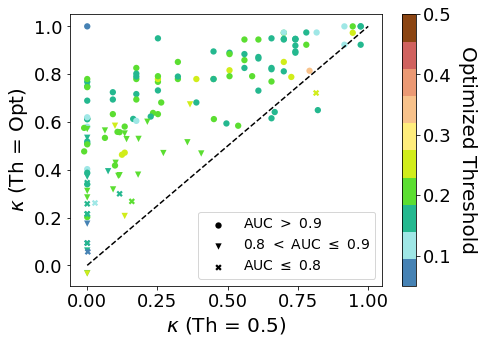

In [39]:
scatterplot_results(df_kappa, df_kappa, df_thresholds, df_auc, 
                    xax = 'standard', yax = 'GHOST', x_lab = "$\kappa$ (Th = 0.5)", y_lab = "$\kappa$ (Th = Opt)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = f"{output_folder}/scatterplot_{basename}_ThOpt_vs_Th05.png", 
                    cmap = cmap3, norm = None, transparency = 1)

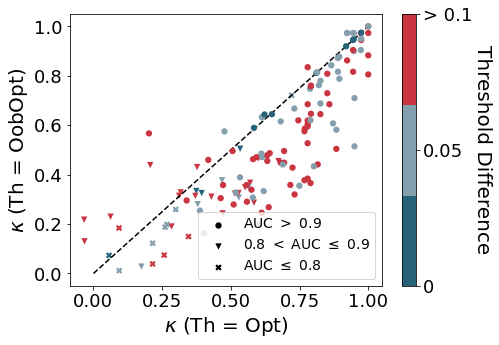

In [40]:
if method == 'RF' and opt_oob:
    scatterplot_results_th_diff(df_kappa, df_kappa, df_thresholds, df_thresholds, df_auc, 
                    xax = 'GHOST', yax = 'OobOpt', x_lab = "$\kappa$ (Th = Opt)", y_lab = "$\kappa$ (Th = OobOpt)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = f"{output_folder}/scatterplot_{basename}_ThOpt_vs_ThOob.png", 
                    cmap = cmap4, norm = None, transparency = 1)

In [41]:
if try_resampling:
    scatterplot_results(df_kappa, df_kappa, df_thresholds, df_auc, 
                    xax = 'SMOTE', yax = 'GHOST', x_lab = "$\kappa$ (SMOTE)", y_lab = "$\kappa$ (Th = Opt)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = f"{output_folder}/scatterplot_{basename}_GHOST_vs_SMOTE.png", 
                    cmap = cmap3, norm = None, transparency = 1)

In [42]:
if try_resampling:
    scatterplot_results(df_kappa, df_kappa, df_thresholds, df_auc, 
                    xax = 'RUS', yax = 'GHOST', x_lab = "$\kappa$ (RUS)", y_lab = "$\kappa$ (Th = Opt)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = f"{output_folder}/scatterplot_{basename}_GHOST_vs_RUS.png", 
                    cmap = cmap3, norm = None, transparency = 1)

### Compare to CP

In [43]:
import glob

if try_cp:
    files_preds = glob.glob(f"results/{basename}_predictions_*.csv")
    ACP_significance_level = 0.2

**Comparison between generalized threshold optimization and CP.**

For a fair comparison, in the plot below, we compare only the predictions where CP produced statistically significant results (at a ACP significance level of 0.2):

In [44]:
# calculate Cohen's kappa only on single predictions
if try_cp:
    assay_ids = []
    kappa_cp = [] 
    kappa_cp_single = [] 
    kappa_th05_single = []
    kappa_thopt_single = []
    for f1 in files_preds:
        assay_ids.append(f1.split('_')[3].replace('.csv',''))
        df_preds1 = pd.read_csv(f1)
        df_preds1['uncertain_CP'] = 0
        df_preds1['uncertain_CP'][df_preds1['p1'] >= df_preds1['p0']] = 1
        tmp = df_preds1.loc[(df_preds1[f'y_pred_{ACP_significance_level}']=="0") | (df_preds1[f'y_pred_{ACP_significance_level}']=="1")]
        print(tmp)
        kappa_cp_single.append(metrics.cohen_kappa_score(tmp.y_true,tmp.uncertain_CP))
        kappa_th05_single.append(metrics.cohen_kappa_score(tmp.y_true,tmp.Th05))
        kappa_thopt_single.append(metrics.cohen_kappa_score(tmp.y_true,tmp.ThOpt))
    df_kappa = df_kappa.reset_index().rename(columns = {'index': 'assay_id'})
    df_cp = pd.DataFrame({'assay_id': assay_ids, 'CP_single': kappa_cp_single, 'Th05_single':kappa_th05_single, 'GHOST_single': kappa_thopt_single})
    df_kappa = pd.merge(df_kappa, df_cp, how = 'left', on = 'assay_id')


In [45]:
if try_cp:
    scatterplot_results(df_kappa, df_kappa, df_thresholds.rename(columns = {'ThOpt': 'ThOpt_single'}), df_auc, 
                    xax = 'CP_single', yax = 'GHOST_single', x_lab = "$\kappa$ (CP, single pred.)", y_lab = "$\kappa$ (Th = Opt, single pred.)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = f"{output_folder}/scatterplot_{basename}_GHOST_vs_CP.png", 
                    cmap = cmap3, norm = None, transparency = 1)